# Fake News Detection using Machine Learning and Deep Learning

### Importing neccessary libraries and Loading the Dataset


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import xgboost as xgb
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,auc, classification_report, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

In [2]:
news_df = pd.read_csv('train (1).csv', names=["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pantson fire","context"])

In [3]:
encoder = LabelEncoder()

news_df['label'] = encoder.fit_transform(news_df['label'])

In [4]:
news_df.head()

,json ID,label,statement,subject,speaker,job title,state,party,barely true,false,half true,mostly true,pantson fire,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
news_df.shape

(10240, 14)

<AxesSubplot:xlabel='label', ylabel='count'>

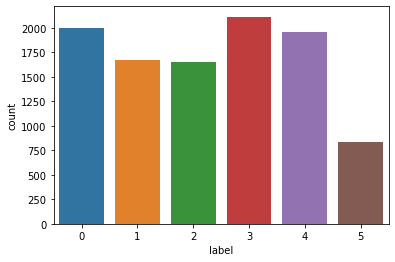

In [6]:
sns.countplot(x='label', data=news_df)

### Data Preprocessing

In [7]:
news_df.isna().sum()

json ID            0
label              0
statement          0
subject            2
speaker            2
job title       2897
state           2208
party              2
barely true        2
false              2
half true          2
mostly true        2
pantson fire       2
context          102
dtype: int64

In [8]:
news_df = news_df.fillna(' ')

In [9]:
news_df.isna().sum()

json ID         0
label           0
statement       0
subject         0
speaker         0
job title       0
state           0
party           0
barely true     0
false           0
half true       0
mostly true     0
pantson fire    0
context         0
dtype: int64

In [10]:
news_df['content'] = news_df['speaker']+" "+news_df['statement']

In [11]:
news_df

,json ID,label,statement,subject,speaker,job title,state,party,barely true,false,half true,mostly true,pantson fire,context,content
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,dwayne-bohac Says the Annies List political gr...
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,scott-surovell When did the decline of coal st...
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,barack-obama Hillary Clinton agrees with John ...
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release,blog-posting Health care reform legislation is...
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,charlie-crist The economic turnaround started ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,4,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",aclu-florida There are a larger number of shar...
10236,3408.json,4,Democrats have now become the party of the [At...,elections,alan-powell,,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,alan-powell Democrats have now become the part...
10237,3959.json,3,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,herman-cain Says an alternative to Social Secu...
10238,2253.json,0,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,jeff-greene On lifting the U.S. Cuban embargo ...


In [12]:
news_df['content']

0        dwayne-bohac Says the Annies List political gr...
1        scott-surovell When did the decline of coal st...
2        barack-obama Hillary Clinton agrees with John ...
3        blog-posting Health care reform legislation is...
4        charlie-crist The economic turnaround started ...
                               ...                        
10235    aclu-florida There are a larger number of shar...
10236    alan-powell Democrats have now become the part...
10237    herman-cain Says an alternative to Social Secu...
10238    jeff-greene On lifting the U.S. Cuban embargo ...
10239    michael-steele The Department of Veterans Affa...
Name: content, Length: 10240, dtype: object

#### Stemming

In [13]:
# stemming
ps = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [14]:
news_df['content'] = news_df['content'].apply(stemming)

In [15]:
news_df['content']

0        dwayn bohac say anni list polit group support ...
1        scott surovel declin coal start start natur ga...
2        barack obama hillari clinton agre john mccain ...
3        blog post health care reform legisl like manda...
4            charli crist econom turnaround start end term
                               ...                        
10235    aclu florida larger number shark attack florid...
10236    alan powel democrat becom parti atlanta metro ...
10237    herman cain say altern social secur oper galve...
10238    jeff green lift u cuban embargo allow travel cuba
10239    michael steel depart veteran affair manual tel...
Name: content, Length: 10240, dtype: object

In [16]:
X = news_df['content'].values
y = news_df['label'].values

In [17]:
print(X)

['dwayn bohac say anni list polit group support third trimest abort demand'
 'scott surovel declin coal start start natur ga took start begin presid georg w bush administr'
 'barack obama hillari clinton agre john mccain vote give georg bush benefit doubt iran'
 ...
 'herman cain say altern social secur oper galveston counti texa meant particip retir whole lot money social secur'
 'jeff green lift u cuban embargo allow travel cuba'
 'michael steel depart veteran affair manual tell veteran stuff like realli valu commun know encourag commit suicid']


#### Applying Tf-idf Vectorizer

In [18]:
vector = TfidfVectorizer()
vector.fit(X)
X = vector.transform(X)

In [19]:
print(X)

  (0, 8589)	0.3751918202191673
  (0, 8394)	0.23689878675511836
  (0, 8134)	0.18140560265636088
  (0, 7275)	0.09977806681983761
  (0, 6384)	0.24245034239270283
  (0, 4880)	0.2688109371967018
  (0, 3542)	0.2476267671895362
  (0, 2497)	0.3751918202191673
  (0, 2126)	0.2933637821280234
  (0, 904)	0.39184405471094097
  (0, 332)	0.3751918202191673
  (0, 20)	0.21620367127779688
  (1, 8483)	0.18955757218746527
  (1, 8148)	0.3462359578971329
  (1, 7916)	0.6344196894551376
  (1, 7369)	0.14430371124325
  (1, 6492)	0.13853137350366376
  (1, 5615)	0.25606057066042914
  (1, 3330)	0.1869894160065197
  (1, 3245)	0.20729745067058047
  (1, 2070)	0.25606057066042914
  (1, 1554)	0.25760502695265536
  (1, 1129)	0.17205069126502603
  (1, 726)	0.2504665588099598
  (1, 95)	0.18417152219787888
  :	:
  (10237, 244)	0.28012392445469614
  (10238, 8552)	0.357672601308624
  (10238, 4850)	0.37742042937774545
  (10238, 4305)	0.2798305031050015
  (10238, 3502)	0.3361535185248456
  (10238, 2615)	0.42005937847455344
  (

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [21]:
X_train.shape

(8192, 9343)

In [22]:
X_test.shape

(2048, 9343)

### Applying ML models

#### Logistic Regression

Confusion Matrix:
 [[126  48  44  99  67  15]
 [ 64  57  28  76 107   3]
 [ 82  35  39  93  77   5]
 [ 90  48  43 132 103   7]
 [ 85  51  34 106 110   6]
 [ 60  14  17  32  23  22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.32      0.28       399
           1       0.23      0.17      0.19       335
           2       0.19      0.12      0.15       331
           3       0.25      0.31      0.27       423
           4       0.23      0.28      0.25       392
           5       0.38      0.13      0.19       168

    accuracy                           0.24      2048
   macro avg       0.25      0.22      0.22      2048
weighted avg       0.24      0.24      0.23      2048

Accuracy: 0.2373046875
Precision: 0.2410426866822797
Recall: 0.2373046875
F1-Score: 0.2300392732597555


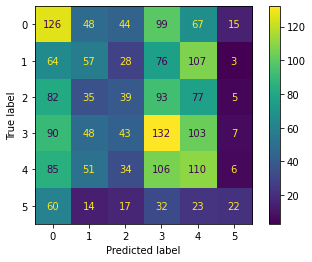

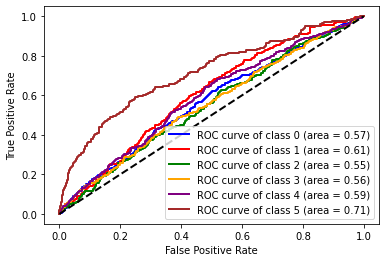

In [23]:
model = LogisticRegression(multi_class='ovr',solver='saga', max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = model.decision_function(X_test)
n_classes = len(model.classes_)
y_test_bin = label_binarize(y_test, classes=model.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Support Vector Machine

Confusion Matrix:
 [[ 93  64  46  80  69  47]
 [ 55  80  30  58  93  19]
 [ 62  48  52  78  63  28]
 [ 71  58  63 109  95  27]
 [ 74  70  53  75  94  26]
 [ 33  11  24  31  25  44]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.23      0.24       399
           1       0.24      0.24      0.24       335
           2       0.19      0.16      0.17       331
           3       0.25      0.26      0.26       423
           4       0.21      0.24      0.23       392
           5       0.23      0.26      0.25       168

    accuracy                           0.23      2048
   macro avg       0.23      0.23      0.23      2048
weighted avg       0.23      0.23      0.23      2048

Accuracy: 0.23046875
Precision: 0.2297079264697538
Recall: 0.23046875
F1-Score: 0.22953757991155366


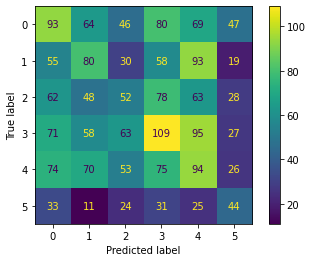

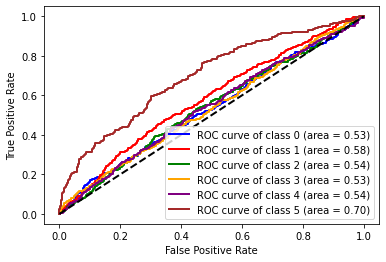

In [24]:
svm_model = OneVsRestClassifier(SVC(kernel='linear'))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = svm_model.decision_function(X_test)
n_classes = len(svm_model.classes_)
y_test_bin = label_binarize(y_test, classes=svm_model.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Naive Bayes

Confusion Matrix:
 [[117  15  16 173  78   0]
 [ 53  20   9 137 115   1]
 [ 79   5  14 161  72   0]
 [ 78   7  19 216 103   0]
 [ 69  13   7 189 114   0]
 [ 66   4   9  67  21   1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.29      0.27       399
           1       0.31      0.06      0.10       335
           2       0.19      0.04      0.07       331
           3       0.23      0.51      0.32       423
           4       0.23      0.29      0.25       392
           5       0.50      0.01      0.01       168

    accuracy                           0.24      2048
   macro avg       0.29      0.20      0.17      2048
weighted avg       0.26      0.24      0.20      2048

Accuracy: 0.2353515625
Precision: 0.2627384241397135
Recall: 0.2353515625
F1-Score: 0.19556610457402585


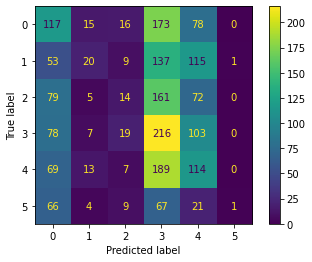

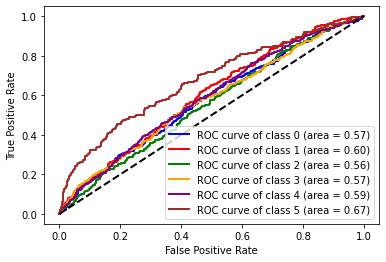

In [25]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = NB.predict_proba(X_test)
n_classes = len(NB.classes_)
y_test_bin = label_binarize(y_test, classes=NB.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Random Forest

Confusion Matrix:
 [[ 85  64  76  56  65  53]
 [ 47  65  46  53  99  25]
 [ 67  48  80  44  60  32]
 [ 72  72  91  68  79  41]
 [ 50  80  63  58 112  29]
 [ 33  18  26  15  24  52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.21      0.23       399
           1       0.19      0.19      0.19       335
           2       0.21      0.24      0.22       331
           3       0.23      0.16      0.19       423
           4       0.26      0.29      0.27       392
           5       0.22      0.31      0.26       168

    accuracy                           0.23      2048
   macro avg       0.22      0.23      0.23      2048
weighted avg       0.23      0.23      0.22      2048

Accuracy: 0.2255859375
Precision: 0.22625861161219699
Recall: 0.2255859375
F1-Score: 0.22353196242219162


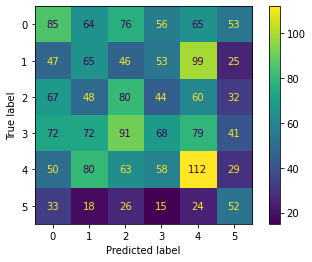

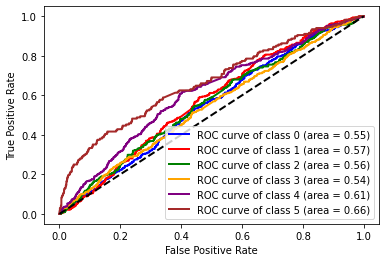

In [26]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='entropy', random_state=42, class_weight='balanced', bootstrap=True)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = clf.predict_proba(X_test)
n_classes = len(clf.classes_)
y_test_bin = label_binarize(y_test, classes=clf.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Passive Aggressive Algorithm

Confusion Matrix:
 [[ 68  71  63  88  69  40]
 [ 57  81  42  66  72  17]
 [ 56  51  62  68  65  29]
 [ 71  74  69 102  88  19]
 [ 84  73  47  65 102  21]
 [ 28  20  35  30  27  28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.17      0.18       399
           1       0.22      0.24      0.23       335
           2       0.19      0.19      0.19       331
           3       0.24      0.24      0.24       423
           4       0.24      0.26      0.25       392
           5       0.18      0.17      0.17       168

    accuracy                           0.22      2048
   macro avg       0.21      0.21      0.21      2048
weighted avg       0.22      0.22      0.22      2048

Accuracy: 0.21630859375
Precision: 0.21506587638108612
Recall: 0.21630859375
F1-Score: 0.21541118035363008


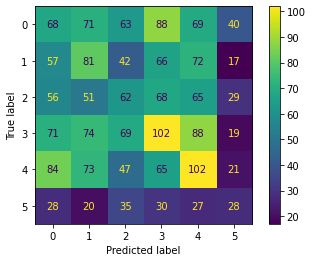

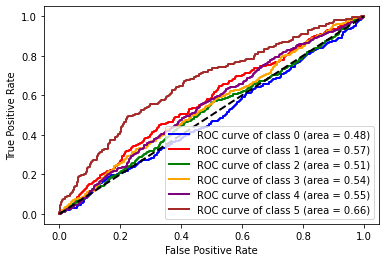

In [27]:
clf = PassiveAggressiveClassifier(max_iter=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = clf.decision_function(X_test)
n_classes = len(clf.classes_)
y_test_bin = label_binarize(y_test, classes=clf.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Decision Tree

Confusion Matrix:
 [[ 26   0   0 340  21  12]
 [  8   0   0 286  39   2]
 [ 16   0   1 284  26   4]
 [ 21   1   0 349  44   8]
 [ 14   2   0 311  57   8]
 [ 13   0   0 122   7  26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.07      0.10       399
           1       0.00      0.00      0.00       335
           2       1.00      0.00      0.01       331
           3       0.21      0.83      0.33       423
           4       0.29      0.15      0.19       392
           5       0.43      0.15      0.23       168

    accuracy                           0.22      2048
   macro avg       0.37      0.20      0.14      2048
weighted avg       0.35      0.22      0.15      2048

Accuracy: 0.22412109375
Precision: 0.34769648466264724
Recall: 0.22412109375
F1-Score: 0.14546661616995463


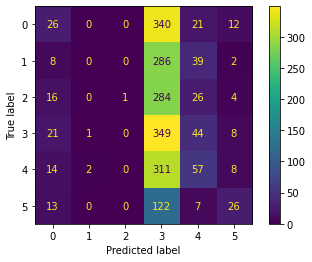

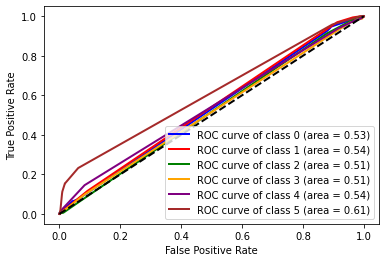

In [28]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
y_prob = clf.predict_proba(X_test)
n_classes = len(clf.classes_)
y_test_bin = label_binarize(y_test, classes=clf.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Confusion Matrix:\n', confusion_mat)
print("\nClassification Report:\n", report)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
confusion_mat_display = ConfusionMatrixDisplay(confusion_mat).plot()
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()